# Model training

The input data is prepared by joining the calculated windfield with damaged values.
Subsampling is done by dropping those rows where the windspeed is 0, the the data stratification is done on damaged values.
The XGBoost Reduced Over fitting model, was trained on this prepared input data with gridcells.
The RMSE calculated in total and per each bin.

In [1]:
%load_ext jupyter_black

In [2]:
from collections import defaultdict
import statistics

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import colorama
from colorama import Fore

from utils import get_training_dataset

/Users/mersedehkooshki/opt/anaconda3/envs/global-storm/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Read csv file (which also damage5years added to it) and import to df
df = get_training_dataset()
df.head()

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,percent_houses_damaged,percent_houses_damaged_5years
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,NaN,0.0,0.0
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,0.0,0.0
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,0.0,0.0
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,0.0,0.0
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,0.0,0.0


#### Check rows including NaN values regarding ['rwi']

In [4]:
# Keep only rows including NaN values
df1 = df[df.isnull().any(axis=1)]

# Estimate number of rows with unique 'grid_point_id' including Nan values
len(df1["grid_point_id"].unique())

224

In [5]:
df["rwi"].isnull().sum()

8736

In [6]:
# Fill NaNs with average estimated value of 'rwi'
df["rwi"].fillna(df["rwi"].mean(), inplace=True)

In [7]:
# Number of damaged values greater than 100
(df["percent_houses_damaged"] > 100).sum()

3

In [8]:
# Set any values >100% to 100%,
for i in range(len(df)):
    if df.loc[i, "percent_houses_damaged"] > 100:
        df.at[i, "percent_houses_damaged"] = float(100)

array([[<AxesSubplot:title={'center':'percent_houses_damaged'}>]],
      dtype=object)

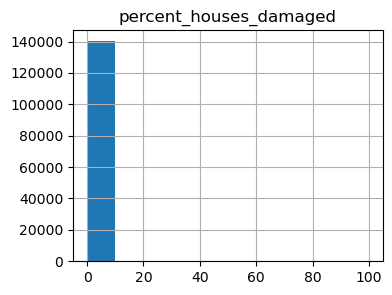

In [9]:
# Show histogram of damage
df.hist(column="percent_houses_damaged", figsize=(4, 3))

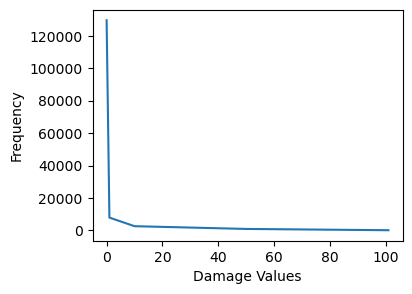

In [10]:
# Hist plot after data stratification
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_houses_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [11]:
# Check the bins' intervalls (first bin means all zeros, second bin means 0 < values <= 1)
df["percent_houses_damaged"].value_counts(bins=binsP2)

(-0.001, 9e-05]    129600
(9e-05, 1.0]         7938
(1.0, 10.0]          2634
(10.0, 50.0]          939
(50.0, 101.0]         147
Name: percent_houses_damaged, dtype: int64

In [12]:
# Remove zeros from wind_speed
df = df[(df[["wind_speed"]] != 0).any(axis=1)]
df = df.drop(columns=["grid_point_id", "typhoon_year"])
df.head()

,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,percent_houses_damaged,percent_houses_damaged_5years
138,DURIAN,12.460039,275.018491,0.670833,0.313021,0.479848,-0.213039,0.0,0.0
139,DURIAN,11.428974,297.027578,0.929167,0.343229,55.649739,0.206000,0.0,0.0
148,DURIAN,13.077471,262.598363,0.716667,0.424479,8.157414,-0.636000,0.0,0.0
149,DURIAN,12.511864,273.639330,0.568750,0.336979,88.292015,-0.227500,0.0,0.0
150,DURIAN,11.977511,284.680297,0.589583,0.290625,962.766739,-0.299667,0.0,0.0


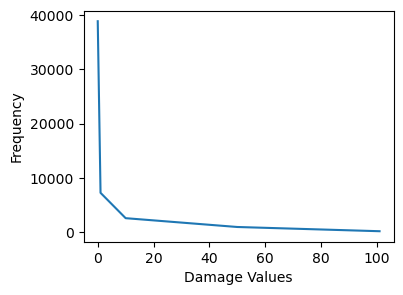

In [13]:
# Hist plot after removing rows where windspeed is 0
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_houses_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [14]:
print(samples_per_bin2)
print(binsP2)

[38901  7232  2552   925   144]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [15]:
# Check the bins' intervalls
df["percent_houses_damaged"].value_counts(bins=binsP2)

(-0.001, 9e-05]    38901
(9e-05, 1.0]        7232
(1.0, 10.0]         2552
(10.0, 50.0]         925
(50.0, 101.0]        144
Name: percent_houses_damaged, dtype: int64

In [16]:
bin_index2 = np.digitize(df["percent_houses_damaged"], bins=binsP2)

In [17]:
y_input_strat = bin_index2

In [18]:
# Defin two lists to save total RMSE of test and train data

test_RMSE = defaultdict(list)
train_RMSE = defaultdict(list)

In [19]:
features = [
    "wind_speed",
    "track_distance",
    "total_houses",
    "rainfall_max_6h",
    "rainfall_max_24h",
    "rwi",
    "percent_houses_damaged_5years",
]

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["percent_houses_damaged"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Index(['wind_speed', 'track_distance', 'total_houses', 'rainfall_max_6h',
       'rainfall_max_24h', 'rwi', 'percent_houses_damaged_5years'],
      dtype='object')

In [20]:
# Run XGBoost Reduced Overfitting in for loop to estimate RMSE per bins

for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, df["percent_houses_damaged"], stratify=y_input_strat, test_size=0.2
    )

    # XGBoost Reduced Overfitting
    xgb = XGBRegressor(
        base_score=0.5,
        booster="gbtree",
        colsample_bylevel=0.8,
        colsample_bynode=0.8,
        colsample_bytree=0.8,
        gamma=3,
        eta=0.01,
        importance_type="gain",
        learning_rate=0.1,
        max_delta_step=0,
        max_depth=4,
        min_child_weight=1,
        missing=1,
        n_estimators=100,
        early_stopping_rounds=10,
        n_jobs=1,
        nthread=None,
        objective="reg:squarederror",
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        seed=None,
        silent=None,
        subsample=0.8,
        verbosity=1,
        eval_metric=["rmse", "logloss"],
        random_state=0,
    )

    eval_set = [(X_test, y_test)]
    xgb_model = xgb.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        verbose=False,
        # sample_weight=pow(y_train, 2),
    )

    X2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    print(est2.summary())

    X2_test = sm.add_constant(X_test)

    y_pred_train_LREG = est2.predict(X2)
    mse_train_idx_LREG = mean_squared_error(y_train, y_pred_train_LREG)
    rmse_train_LREG = np.sqrt(mse_train_idx_LREG)

    ypred_LREG = est2.predict(X2_test)
    mse_idx_LREG = mean_squared_error(y_test, ypred_LREG)
    rmse_LREG = np.sqrt(mse_idx_LREG)

    print("----- Training ------")
    print(f"LREG Root mean squared error: {rmse_train_LREG:.2f}")
    print("----- Test ------")
    print(f"LREG Root mean squared error: {rmse_LREG:.2f}")

    # Calculate RMSE in total

    y_pred_train = xgb.predict(X_train)
    mse_train_idx = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train_idx)

    y_pred = xgb.predict(X_test)
    mse_idx = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse_idx)

    print("----- Training ------")
    print(f"Root mean squared error: {rmse_train:.2f}")

    print("----- Test ------")
    print(f"Root mean squared error: {rmse:.2f}")

    test_RMSE["all"].append(rmse)
    train_RMSE["all"].append(rmse_train)

    # Calculate RMSE per bins

    bin_index_test = np.digitize(y_test, bins=binsP2)
    bin_index_train = np.digitize(y_train, bins=binsP2)

    # Estimation of RMSE for train data
    y_pred_train = xgb.predict(X_train)
    for bin_num in range(1, 6):

        mse_train_idx = mean_squared_error(
            y_train[bin_index_train == bin_num],
            y_pred_train[bin_index_train == bin_num],
        )
        rmse_train = np.sqrt(mse_train_idx)

        # Estimation of RMSE for test data
        y_pred = xgb.predict(X_test)

        mse_idx = mean_squared_error(
            y_test[bin_index_test == bin_num],
            y_pred[bin_index_test == bin_num],
        )
        rmse = np.sqrt(mse_idx)

        train_RMSE[bin_num].append(rmse_train)
        test_RMSE[bin_num].append(rmse)

[17:47:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


                              OLS Regression Results                              
Dep. Variable:     percent_houses_damaged   R-squared:                       0.204
Model:                                OLS   Adj. R-squared:                  0.204
Method:                     Least Squares   F-statistic:                     1455.
Date:                    Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                            17:47:25   Log-Likelihood:            -1.1658e+05
No. Observations:                   39803   AIC:                 

In [21]:
# Define a function to plot RMSEs
def rmse_bin_plot(te_rmse, tr_rmse, min_rg, max_rg, step):

    m_test_rmse = statistics.mean(te_rmse)
    plt.figure(figsize=(4, 3))
    plt.axvline(m_test_rmse, color="red", linestyle="dashed")
    plt.hist(
        te_rmse,
        bins=np.arange(min_rg, max_rg, step),
        edgecolor="k",
        histtype="bar",
        density=True,
    )
    sd_test_rmse = statistics.stdev(te_rmse)

    m_train_rmse = statistics.mean(tr_rmse)
    plt.axvline(m_train_rmse, color="b", linestyle="dashed")
    plt.hist(
        tr_rmse,
        bins=np.arange(min_rg, max_rg, step),
        color="orange",
        edgecolor="k",
        histtype="bar",
        density=True,
        alpha=0.7,
    )
    sd_train_rmse = statistics.stdev(tr_rmse)

    print(Fore.RED)
    print(f"stdev_RMSE_test: {sd_test_rmse:.2f}")
    print(f"stdev_RMSE_train: {sd_train_rmse:.2f}")

    print(f"mean_RMSE_test: {m_test_rmse:.2f}")
    print(f"mean_RMSE_train: {m_train_rmse:.2f}")

    # create legend
    labels = ["Mean_test", "Mean_train", "test", "train"]
    plt.legend(labels)

    plt.xlabel("The RMSE error")
    plt.ylabel("Frequency")
    plt.title("histogram of the RMSE distribution")
    plt.show()

## Plot RMSE in total

RMSE in total 


stdev_RMSE_test: 0.15
stdev_RMSE_train: 0.04
mean_RMSE_test: 3.28
mean_RMSE_train: 2.70


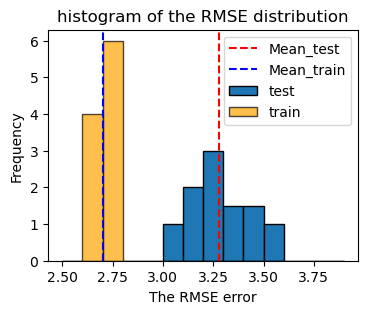

In [23]:
print("RMSE in total", "\n")
rmse_bin_plot(test_RMSE["all"], train_RMSE["all"], 2.5, 4.0, 0.1)

## Plot RMSE per bin

RMSE per bin 1


stdev_RMSE_test: 0.18
stdev_RMSE_train: 0.02
mean_RMSE_test: 0.96
mean_RMSE_train: 0.79


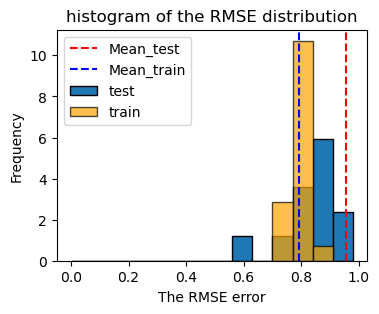

RMSE per bin 2


stdev_RMSE_test: 0.23
stdev_RMSE_train: 0.04
mean_RMSE_test: 1.96
mean_RMSE_train: 1.67


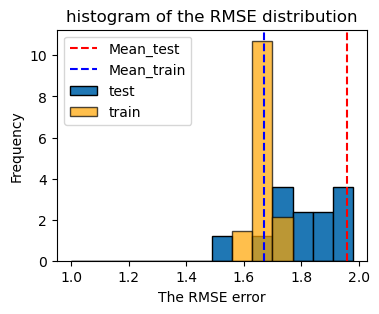

RMSE per bin 3


stdev_RMSE_test: 0.47
stdev_RMSE_train: 0.08
mean_RMSE_test: 4.83
mean_RMSE_train: 4.00


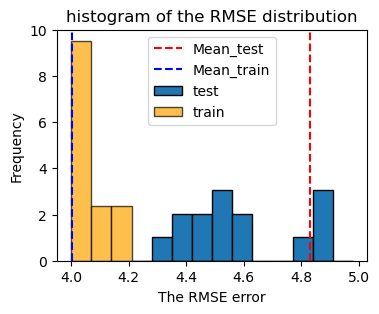

RMSE per bin 4


stdev_RMSE_test: 0.95
stdev_RMSE_train: 0.19
mean_RMSE_test: 14.74
mean_RMSE_train: 13.16


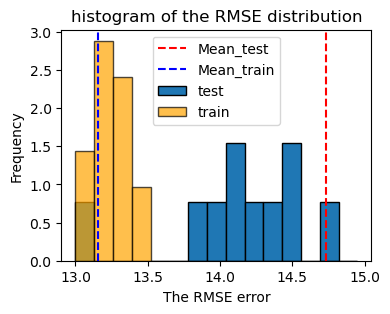

RMSE per bin 5


stdev_RMSE_test: 3.47
stdev_RMSE_train: 0.98
mean_RMSE_test: 37.88
mean_RMSE_train: 28.68


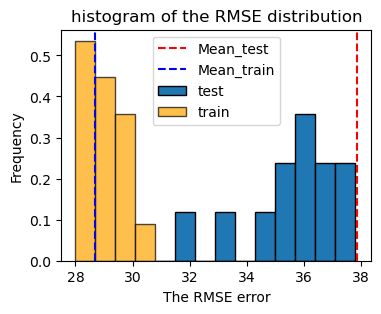

In [27]:
bin_params = {
    1: (0.0, 1.0, 0.07),
    2: (1.0, 2.0, 0.07),
    3: (4.0, 5.0, 0.07),
    4: (13.0, 15.0, 0.13),
    5: (28.0, 38.0, 0.7),
}


for bin_num in range(1, 6):

    print(f"RMSE per bin {bin_num}\n")
    rmse_bin_plot(test_RMSE[bin_num], train_RMSE[bin_num], *bin_params[bin_num])